In [1]:
import pandas as pd
import pymysql
import seaborn as sns 
from matplotlib import pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import accuracy_score

### **ESTABLISHING AND TESTING CONNECTION**

In [2]:
conn = pymysql.connect(
    host = 'localhost',
    user = 'root',
    password = 'DMAProject',
    db = 're'
)

In [3]:
cur = conn.cursor()

In [4]:
cur.execute("select @@version")

1

In [5]:
output = cur.fetchall()

In [6]:
print(output)

(('8.0.31',),)


### **QUERY TO GET THE REQUIRED DATA**

In [25]:
cur.execute('''select * from property_listing''')

300

In [26]:
data =  cur.fetchall()

In [27]:
data = pd.DataFrame(data)

In [28]:
data.columns = ['propID','creationDate','rate','region','type','status','size']

### **VISUALIZE THE DATA AS IS**

C:\Users\raori\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='creationDate', ylabel='rate'>

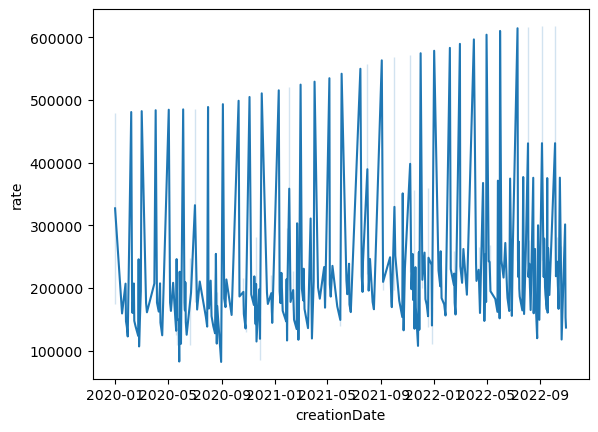

In [29]:
sns.lineplot(data['creationDate'], data['rate'])

### **CALCULATE RATE PER SQFT AND SELECT ONLY 1-2 BEDROOMS TO REMOVE MAGNITUDE BIAS**

In [30]:
data = data[data['type'].isin(['1-bedroom','2-bedroom'])]

In [31]:
data['Rate_per_sqft'] = data['rate']/data['size']

In [32]:
data['Rate_per_sqft'] = data['Rate_per_sqft'].round(2)
data['Rate_per_sqft']

0      240.29
1      227.31
2      310.84
3      193.29
4      279.03
        ...  
294    140.19
296    187.56
297    302.04
298    155.44
299    209.79
Name: Rate_per_sqft, Length: 229, dtype: float64

In [34]:
data

,propID,creationDate,rate,region,type,status,size,Rate_per_sqft
0,PL01,2020-01-01,479372,"New York, NY",2-bedroom,Sold,1995,240.29
1,PL02,2020-01-01,175030,"Buffalo, NY",1-bedroom,Unsold,770,227.31
2,PL03,2020-01-17,159459,"Rochester, NY",1-bedroom,Unsold,513,310.84
3,PL04,2020-01-25,207014,"Albany, NY",2-bedroom,Sold,1071,193.29
4,PL05,2020-01-26,147048,"Syracuse, NY",1-bedroom,Unsold,527,279.03
...,...,...,...,...,...,...,...,...
294,PL94,2020-11-28,85938,"Plattsburgh, NY",1-bedroom,Reserved,613,140.19
296,PL96,2020-12-14,192439,"Olean, NY",2-bedroom,Sold,1026,187.56
297,PL97,2020-12-16,174582,"Hudson, NY",1-bedroom,Reserved,578,302.04
298,PL98,2020-12-24,221503,"Oneonta, NY",2-bedroom,Sold,1425,155.44


### **SPLIT THE DATA AND RUN THE ARIMA ALGORITHM**

In [35]:
# split data into train and test sets
data = data.Rate_per_sqft
X = data.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

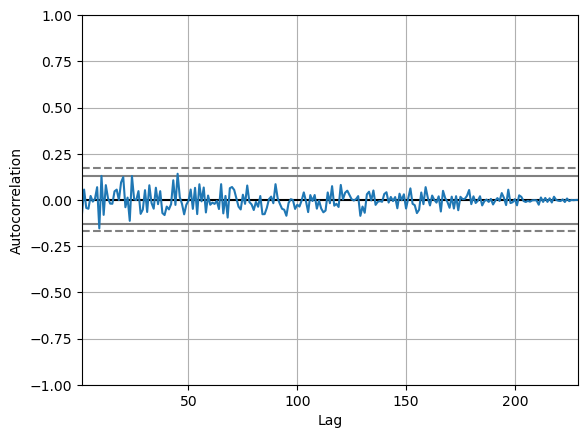

In [36]:
# creating the autocorrelation plot to determine the AR parameter of the ARIMA model
autocorrelation_plot(data)
plt.show()

In [37]:
# walk-forward validation
predictions = []
for t in range(len(test)):
 model = ARIMA(history, order=(2,1,0))
 model_fit = model.fit()
 output = model_fit.forecast()
 yhat = output[0]
 predictions.append(yhat)
 obs = test[t]
 history.append(obs)
 print('predicted=%f, expected=%f' % (yhat, obs))

predicted=210.626429, expected=172.590000
predicted=205.464420, expected=249.820000
predicted=206.227907, expected=225.990000
predicted=220.973330, expected=268.950000
predicted=244.814110, expected=328.250000
predicted=273.546668, expected=192.600000
predicted=273.562895, expected=187.140000
predicted=230.236143, expected=158.160000
predicted=180.218825, expected=145.410000
predicted=162.485527, expected=261.200000
predicted=182.527675, expected=261.150000
predicted=229.061762, expected=196.650000
predicted=242.063629, expected=179.530000
predicted=209.505461, expected=163.640000
predicted=179.440319, expected=208.290000
predicted=181.508340, expected=179.230000
predicted=187.180131, expected=193.350000
predicted=191.517558, expected=207.210000
predicted=193.624794, expected=101.300000
predicted=171.613971, expected=198.830000
predicted=159.898239, expected=261.650000
predicted=189.931043, expected=203.090000
predicted=226.139256, expected=191.730000
predicted=216.303027, expected=187

In [38]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.2f' % rmse)

Test RMSE: 66.09


### **PLOT ACTUALS VS EXPECTED**

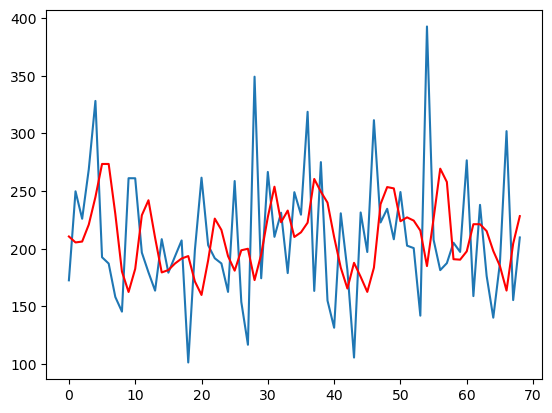

In [39]:
# plot forecasts against actual outcomes
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()